# 23_04_25_03_erythroid_lineage_下游分析3_转录爆发基因的单个速率基因查看

In [9]:
import sys
sys.path = ["../.."] + sys.path # 切换到项目目录下

import scanpy as sc
import scvelo as scv
import velovgi

## 1. 读取结果

In [10]:
# adata_dir = "tmp/erythroid_lineage/adata"
adata_dir = "tmp/erythroid_lineage2/adata"
adata = velovgi.tl.read_adata(adata_dir)
batch_key = "stage"
cluster_key = "celltype"
adata

load tmp/erythroid_lineage2/adata/adata.h5ad
load tmp/erythroid_lineage2/adata/sample_recover.pkl


AnnData object with n_obs × n_vars = 500 × 2000
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'is_sampled', 'velocity_self_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'celltype_colors', 'neighbors', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'sample_recover'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    layers: 'Ms', 'Mu', 'fit_t', 'spliced', 'unspliced', 'velocity', 'velocity_u'
    obsp: 'connectivities', 'distances'

2. subsample_adata

In [11]:
subsample_adata = scv.read("./tmp/erythroid_lineage2/subsample_adata.h5ad")
subsample_adata

AnnData object with n_obs × n_vars = 250 × 2000
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltype_colors', 'neighbors'
    obsm: 'X_pca', 'X_umap'
    layers: 'Ms', 'Mu', 'fit_t', 'latent_time_velovi', 'spliced', 'unspliced', 'velocity', 'velocity_u'
    obsp: 'connectivities', 'distances'

3. model

In [12]:
# velovgi_model = velovgi.tl.VELOVGI.load("tmp/erythroid_lineage/model", adata=adata, use_gpu=True)
velovgi_model = velovgi.tl.VELOVGI.load("tmp/erythroid_lineage2/model", adata=adata, use_gpu=True)

INFO     File tmp/erythroid_lineage2/model/model.pt already downloaded                                             


## 2. 单个基因的速率图(这里moment出问题,导致算出的adata.layer中的spliced和unspliced不能直接用)

In [13]:
# gene_list = ["Hba-x", "Hbb-y", "Smlm1"]
# for gene in gene_list:
#     if gene not in list(adata.var.index):
#         print(gene)
# 此处MRURK基因Smlm1暂时不存在，应该是过滤高变基因的时候过滤掉了，无伤大雅，整体数据集不抽样的话应该就过滤不掉了。

gene_list = ["Hba-x", "Hbb-y"]

In [14]:
if type(adata.layers["velocity_u"]) != adata.layers["velocity"]:
    adata.layers["velocity_u"] = adata.layers["velocity_u"].A

1. 一维速率(原本只有velocity,没有velocity_u)

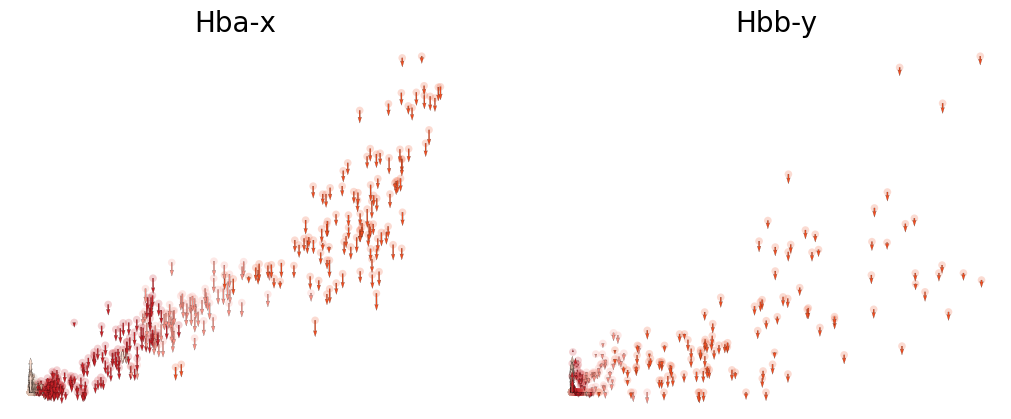

In [15]:
kwargs = dict(frameon=False, fontsize=20)

# TODO: 需要展现一下二维速率图
scv.pl.velocity_embedding(adata, basis=gene_list, color=cluster_key, **kwargs)
# scv.pl.velocity_embedding(subsample_adata, basis=gene_list, color=cluster_key, **kwargs)

2. 二维速率，需要提取unspliced的速率，要从模型中重新拿

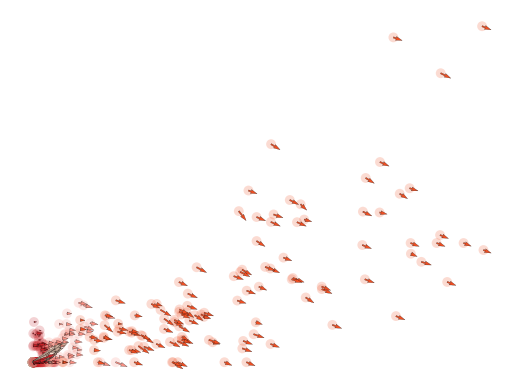

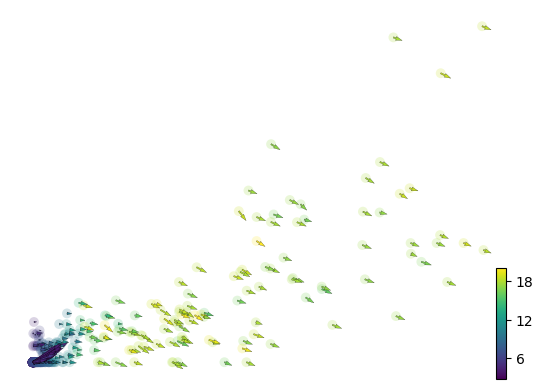

In [16]:
# murk_gene = "Hba-x"
murk_gene = "Hbb-y"
time_key = "latent_time"

adata.obs[time_key] = adata[:, murk_gene].layers["fit_t"].A[:, 0] # 提取该基因的时间

v_kwargs={'vkey': 'velocity', 'size': 200, 'frameon': False, 'title': '',
          'legend_loc': 'none', 'linewidth': .15, "angles": "uv"} # 这里绘制箭头的angles参数是发现bug的地方

scv.pl.velocity_embedding(adata, basis=murk_gene, color=cluster_key, **v_kwargs)
scv.pl.velocity_embedding(adata, basis=murk_gene, color=time_key, colorbar=True, **v_kwargs)

3. 为了确保结果准确，选择少一点的细胞个数或者手动指定速率,在这里调试发现,是scv.pl.velocity_embedding绘制箭头参数的angles参数有问题(https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.quiver.html#matplotlib.axes.Axes.quiver)

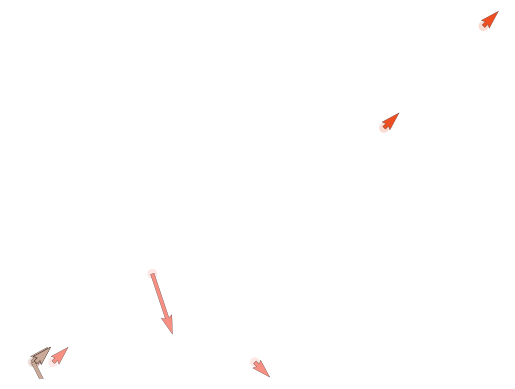

In [19]:
import numpy as np

topn=10
tmp_adata = subsample_adata[:topn, murk_gene]

tmp_adata.layers["spliced"] = tmp_adata.layers["spliced"].A
tmp_adata.layers["unspliced"] = tmp_adata.layers["unspliced"].A

# print(type(tmp_adata.layers["spliced"]), type(tmp_adata.layers["unspliced"]))
# print(tmp_adata[:, murk_gene].layers["velocity"], tmp_adata[:, murk_gene].layers["velocity_u"])

# # 手动指定s,u的速率
tmp_adata.layers["velocity"] = np.array([1,1,1,1,1,1,1,1,1,1]).reshape(10,1)
tmp_adata.layers["velocity_u"] = np.array([1,1,1,-1,1,1,1,-2,1,-3]).reshape(10,1)

# # TODO: 出Bug的地方,没有u是在s上的一维速率,有了u是在u上的一维速率(按道理应该是二位速率了)
# del tmp_adata.layers["velocity_u"]

scv.pl.velocity_embedding(tmp_adata, basis=murk_gene, color=cluster_key, **v_kwargs)